In [3]:
#!pip install pyreadr

     |████████████████████████████████| 329 kB 8.2 MB/s eta 0:00:01


In [40]:
# Import Libraries
import pandas as pd
import altair as alt
import seaborn as sns
import matplotlib.pyplot as plt
import pyreadr
import numpy as np

# set the plotting style
sns.set_style("whitegrid")

# Train-test splits
from sklearn.model_selection import train_test_split

#Model preprocessing
from sklearn import preprocessing

# Models
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler

# PCA
from sklearn.decomposition import PCA

# Model metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Time Series Analysis
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA

In [5]:
# Read the data from .RDS files
import pyreadr
data =  pyreadr.read_r('2019_1min_df.RDS')
df_2019 = data[None]
data = pyreadr.read_r('2020_1min_df.RDS')
df_2020 = data[None]
data = pyreadr.read_r('2021_1min_df.RDS')
df_2021 = data[None]
data = pyreadr.read_r('2022_1min_df.RDS')
df_2022 = data[None]
data = pyreadr.read_r('2023_1min_df.RDS')
df_2023 = data[None]

# Merge all the dataframes to form one dataframe.
df = pd.concat([df_2019, df_2020, df_2021, df_2022, df_2023], ignore_index=True)
df.shape

(2629440, 10)

## Calculations:
Tasks: Start by calculating inflow by logic in inflow text file - see how it compares to headwater and discharge at the dam is increasing or decreasing


In [6]:
df.describe()

,Wells_Total_Discharge,Chelan_Flow,Entiat_Flow,Rocky_Reach_Total_Discharge,Wenatchee_Flow,Rock_Island_Total_Discharge,Rock_Island_Headwater_Elevation,Rocky_Reach_Headwater_Elevation
count,2.629437e+06,2.628614e+06,2.599684e+06,2.628593e+06,2.629414e+06,2.628071e+06,2.628062e+06,2.628547e+06
mean,1.021201e+02,1.955057e+00,4.529274e-01,1.008323e+02,3.016884e+00,1.046683e+02,6.121288e+02,7.056989e+02
std,4.753494e+01,1.290512e+00,5.975219e-01,4.789661e+01,3.142642e+00,4.915503e+01,5.344702e-01,6.839695e-01
min,0.000000e+00,8.425638e-02,0.000000e+00,0.000000e+00,2.312541e-01,0.000000e+00,6.093096e+02,7.031324e+02
25%,6.549712e+01,9.169499e-01,1.200000e-01,6.534334e+01,1.066280e+00,6.883686e+01,6.118340e+02,7.051983e+02
50%,9.900158e+01,2.354010e+00,1.940000e-01,9.878094e+01,1.925941e+00,1.029894e+02,6.122202e+02,7.057149e+02
75%,1.312575e+02,2.464810e+00,4.490000e-01,1.297405e+02,3.596806e+00,1.349106e+02,6.125552e+02,7.062491e+02
max,3.211126e+02,8.677835e+00,4.260000e+00,3.216894e+02,5.120000e+01,3.256689e+02,6.132418e+02,7.078147e+02


In [7]:
# Fillna
df.fillna(method = 'ffill', inplace = True)
df.fillna(method = 'bfill',inplace = True)
df.head()

,datetime_utc,datetime_stamp,Wells_Total_Discharge,Chelan_Flow,Entiat_Flow,Rocky_Reach_Total_Discharge,Wenatchee_Flow,Rock_Island_Total_Discharge,Rock_Island_Headwater_Elevation,Rocky_Reach_Headwater_Elevation
0,2019-01-01T08:00:00Z,2019-01-01 08:00:00,64.991571,2.387225,0.0,72.286020,1.823813,95.571837,612.805419,705.512061
1,2019-01-01T08:01:00Z,2019-01-01 08:01:00,59.312555,2.387256,0.0,68.821629,1.823704,95.675746,612.793892,705.510341
2,2019-01-01T08:02:00Z,2019-01-01 08:02:00,51.471802,2.387287,0.0,66.502634,1.823594,94.028171,612.812751,705.515385
3,2019-01-01T08:03:00Z,2019-01-01 08:03:00,54.252264,2.387319,0.0,63.876623,1.823484,93.075551,612.836556,705.546697
4,2019-01-01T08:04:00Z,2019-01-01 08:04:00,55.120167,2.387350,0.0,62.371067,1.823375,93.617712,612.834370,705.581749


In [8]:
df.isna().sum()

datetime_utc                       0
datetime_stamp                     0
Wells_Total_Discharge              0
Chelan_Flow                        0
Entiat_Flow                        0
Rocky_Reach_Total_Discharge        0
Wenatchee_Flow                     0
Rock_Island_Total_Discharge        0
Rock_Island_Headwater_Elevation    0
Rocky_Reach_Headwater_Elevation    0
dtype: int64

## Rocky Reach Inflow Calculation
Wells Flow Impact = flows averaged from previous 90-105 minutes Chelan Flow Impact = flows averaged from previous 62-77 minutes (60-75 should be fine) Entiat Flow Impact = flows averaged from previous 15-30 minutes

Rocky Reach Inflow = Wells Flow Impact + Chelan Flow Impact + Entiat Flow Impact

In [9]:
# Converting 'datetime_utc' to datetime format
df['datetime_utc'] = pd.to_datetime(df['datetime_utc'])

# Wells Flow Impact (flows averaged from previous 90-105 minutes)
df['Wells_Flow_Impact'] = df['Wells_Total_Discharge'].shift(105).rolling(window=16).mean()
df['Wells_Flow_Impact'].fillna(method='bfill', inplace=True)

# Chelan Flow Impact (flows averaged from previous 60-77 minutes)
df['Chelan_Flow_Impact'] = df['Chelan_Flow'].shift(77).rolling(window=16).mean()
df['Chelan_Flow_Impact'].fillna(method='bfill', inplace=True)

# Entiat Flow Impact (flows averaged from previous 15-30 minutes)
df['Entiat_Flow_Impact'] = df['Entiat_Flow'].shift(30).rolling(window=16).mean()
df['Entiat_Flow_Impact'].fillna(method='bfill', inplace=True)

# Calculate Rocky Reach Inflow
df['Rocky_Reach_Inflow'] = df['Wells_Flow_Impact'] + df['Chelan_Flow_Impact'] + df['Entiat_Flow_Impact']

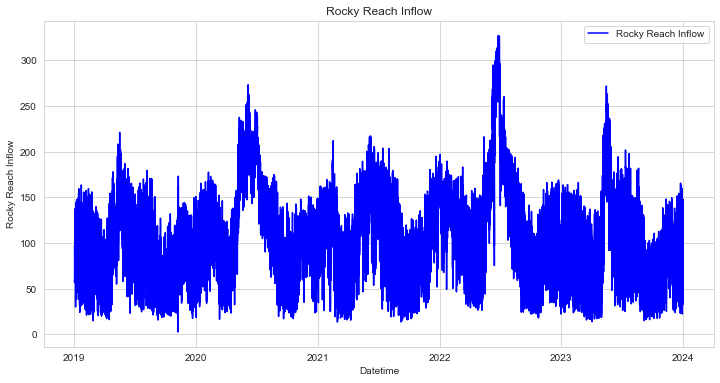

In [10]:
# Plotting Rocky Reach inflow
plt.figure(figsize=(12, 6))
plt.plot(df['datetime_utc'], df['Rocky_Reach_Inflow'], label='Rocky Reach Inflow', color='blue')
plt.title('Rocky Reach Inflow')
plt.xlabel('Datetime')
plt.ylabel('Rocky Reach Inflow')
plt.legend()
plt.show()

## Rock Island Inflow Calculations:
Rocky Reach Flow Impact = Depends on Rocky Reach Total Discharge (RRTD) at time (now) Wenatchee Flow Impact = flow from 22 minutes ago

Rocky Reach Flow Timing Logic:

If RRTD <= 50, then Rocky Reach Flow Impact = RRTD from 43 min ago If RRTD > 50 & RRTD <= 80, then Rocky Reach Flow Impact = RRTD from 45 min ago If RRTD > 80 & RRTD <= 120, then Rocky Reach Flow Impact = RRTD from 47 min ago If RRTD > 120 & RRTD <= 150, then Rocky Reach Flow Impact = RRTD from 48 min ago If RRTD > 150 & RRTD <= 220, then Rocky Reach Flow Impact = RRTD from 50 min ago If RRTD > 220, then Rocky Reach Flow Impact = RRTD from 50 min ago

Rock Island Inflow = Rocky Reach Flow Impact + Wenatchee Flow Impact

In [11]:
# Define the conditions and corresponding shifts
conditions = [50, 80, 120, 150, 220]
shifts = [43, 45, 47, 48, 50]

# Calculate 'Rocky_Reach_Flow_Impact' in a vectorized way
df['Rocky_Reach_Flow_Impact'] = np.select(
    [df['Rocky_Reach_Total_Discharge'] <= condition for condition in conditions],
    [df['Rocky_Reach_Total_Discharge'].shift(shift) for shift in shifts],
    default=df['Rocky_Reach_Total_Discharge'].shift(50)
)
# For starting rows
df['Rocky_Reach_Flow_Impact'].fillna(method='bfill', inplace=True)

# Calculate 'Wenatchee_Flow_Impact' with backward filling
df['Wenatchee_Flow_Impact'] = df['Wenatchee_Flow'].shift(22)
# For starting rows
df['Wenatchee_Flow_Impact'].fillna(method='bfill', inplace=True)

# Calculate 'Rock Island Inflow'
df['Rock_Island_Inflow'] = df['Rocky_Reach_Flow_Impact'] + df['Wenatchee_Flow_Impact']

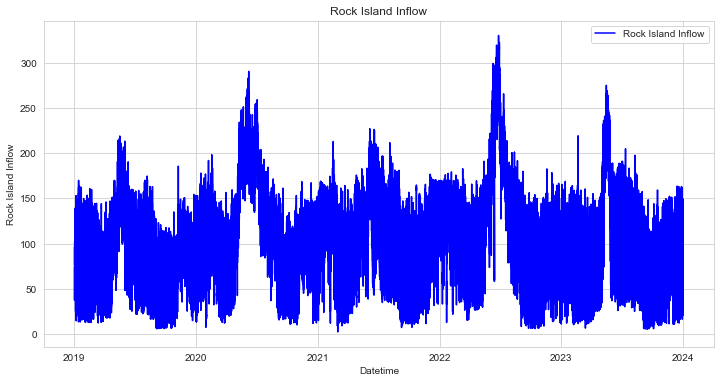

In [12]:
# Plotting Inflow overtime
plt.figure(figsize=(12, 6))
plt.plot(df['datetime_utc'], df['Rock_Island_Inflow'], label='Rock Island Inflow', color='blue')
plt.title('Rock Island Inflow')
plt.xlabel('Datetime')
plt.ylabel('Rock Island Inflow')
plt.legend()
plt.show()

## Calculating the fill rate for each dam:

In [13]:
# Calculate fill rate at both dams
df['Rocky_Reach_Fill_Rate'] = df['Rocky_Reach_Inflow'] - df['Rocky_Reach_Total_Discharge']
df['Rock_Island_Fill_Rate'] = df['Rock_Island_Inflow'] - df['Rock_Island_Total_Discharge']

# Display the updated DataFrame
df[['Rocky_Reach_Fill_Rate','Rock_Island_Fill_Rate']].head()

,Rocky_Reach_Fill_Rate,Rock_Island_Fill_Rate
0,-13.758636,-21.462003
1,-10.294244,-21.565912
2,-7.975250,-19.918337
3,-5.349238,-18.965717
4,-3.843683,-19.507878


We can see how the averages of the rock island fill rate are in the negative while the rocky reach dam is positive.

## Comparing fill/draft with changes to headwater elevation:

### Rocky Reach:

In [14]:
# Calculate the change in Rocky Reach headwater elevation
df['Rocky_Reach_Headwater_Elevation_Change'] = df['Rocky_Reach_Headwater_Elevation'].diff()
df['Rocky_Reach_Headwater_Elevation_Change'].fillna(method='ffill', inplace=True)
df['Rocky_Reach_Headwater_Elevation_Change'].fillna(method='bfill', inplace=True)

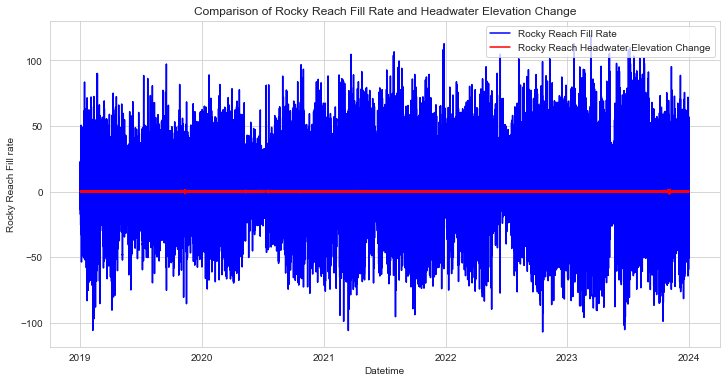

In [15]:
# Plotting comparison
plt.figure(figsize=(12, 6))
plt.plot(df['datetime_utc'], df['Rocky_Reach_Fill_Rate'], label='Rocky Reach Fill Rate', color='blue')
plt.plot(df['datetime_utc'], df['Rocky_Reach_Headwater_Elevation_Change'], label='Rocky Reach Headwater Elevation Change', color = 'red')
plt.title('Comparison of Rocky Reach Fill Rate and Headwater Elevation Change')
plt.xlabel('Datetime')
plt.ylabel('Rocky Reach Fill rate')
plt.legend(loc="upper right")
plt.show()

In [16]:
rocky_corr = df['Rocky_Reach_Fill_Rate'].corr(df['Rocky_Reach_Headwater_Elevation_Change'])
print("Correlation:", rocky_corr)

Correlation: 0.04955411341279854


### Rock Island:

In [17]:
# Calculate the change in Rock island headwater elevation
df['Rock_Island_Headwater_Elevation_Change'] = df['Rock_Island_Headwater_Elevation'].diff()
df['Rock_Island_Headwater_Elevation_Change'].fillna(method='ffill', inplace=True)
df['Rock_Island_Headwater_Elevation_Change'].fillna(method='bfill', inplace=True)

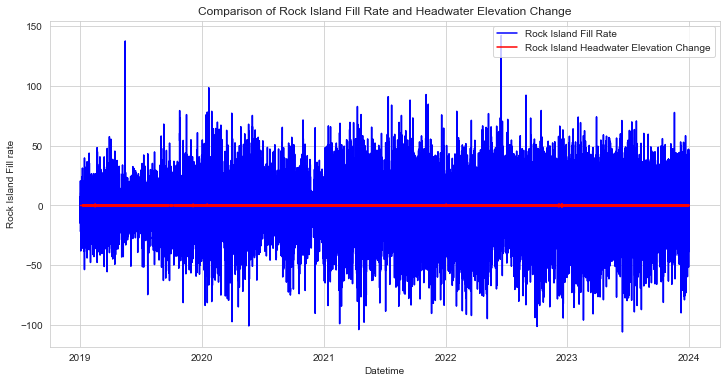

In [18]:
# Plotting comparison
plt.figure(figsize=(12, 6))
plt.plot(df['datetime_utc'], df['Rock_Island_Fill_Rate'], label='Rock Island Fill Rate', color='blue')
plt.plot(df['datetime_utc'], df['Rock_Island_Headwater_Elevation_Change'], label='Rock Island Headwater Elevation Change', color = 'red')
plt.title('Comparison of Rock Island Fill Rate and Headwater Elevation Change')
plt.xlabel('Datetime')
plt.ylabel('Rock Island Fill rate')
plt.legend(loc="upper right")
plt.show()

In [19]:
rock_corr = df['Rock_Island_Fill_Rate'].corr(df['Rock_Island_Headwater_Elevation_Change'])
print("Correlation:", rock_corr)

Correlation: 0.3351018220288516


## Modeling in 30 minute average intervals: 

### Rocky Reach:

In [20]:
df['datetime_utc'] = pd.to_datetime(df['datetime_utc'])
# Set datetime as the index
df.set_index('datetime_utc', inplace=True)
# Resample the data into 30-minute intervals and calculate the mean
df_resampled = df.resample('30T').mean()

# Reset index to have datetime_utc as a regular column
df_resampled.reset_index(inplace=True)

# Prepare data for modeling for Rocky Reach Dam using the resampled data
X_rocky_reach = df_resampled[['Rocky_Reach_Fill_Rate']]
y_rocky_reach = df_resampled['Rocky_Reach_Headwater_Elevation_Change']

In [21]:
df_resampled.head()

,datetime_utc,Wells_Total_Discharge,Chelan_Flow,Entiat_Flow,Rocky_Reach_Total_Discharge,Wenatchee_Flow,Rock_Island_Total_Discharge,Rock_Island_Headwater_Elevation,Rocky_Reach_Headwater_Elevation,Wells_Flow_Impact,Chelan_Flow_Impact,Entiat_Flow_Impact,Rocky_Reach_Inflow,Rocky_Reach_Flow_Impact,Wenatchee_Flow_Impact,Rock_Island_Inflow,Rocky_Reach_Fill_Rate,Rock_Island_Fill_Rate,Rocky_Reach_Headwater_Elevation_Change,Rock_Island_Headwater_Elevation_Change
0,2019-01-01 08:00:00+00:00,56.131330,2.387677,0.0,60.520830,1.822119,90.628069,612.815965,705.555262,56.139926,2.387459,0.0,58.527385,72.286020,1.823711,74.109731,-1.993445,-16.518337,0.003113,-0.000622
1,2019-01-01 08:30:00+00:00,55.433639,2.388613,0.0,52.634011,1.818484,78.723236,612.801513,705.628792,56.139926,2.387459,0.0,58.527385,67.723416,1.821157,69.544572,5.893373,-9.178664,0.001700,-0.001349
2,2019-01-01 09:00:00+00:00,58.328788,2.389549,0.0,40.262839,1.814839,55.801906,612.827773,705.751023,56.139926,2.387459,0.0,58.527385,56.116463,1.817512,57.933974,18.264546,2.132069,0.002475,0.003326
3,2019-01-01 09:30:00+00:00,58.106455,2.390484,0.0,48.422503,1.811194,45.582562,612.795606,705.648621,56.139926,2.387852,0.0,58.527778,44.228276,1.813867,46.042142,10.105274,0.459580,-0.004288,-0.002440
4,2019-01-01 10:00:00+00:00,58.851311,2.391420,0.0,54.805165,1.807549,31.037409,612.778841,705.591932,55.700151,2.388784,0.0,58.088936,43.445364,1.810222,45.255586,3.283771,14.218177,-0.000106,0.003774


In [22]:
# Split the data into training and testing sets
X_train_rocky_reach, X_test_rocky_reach, y_train_rocky_reach, y_test_rocky_reach = train_test_split(
    X_rocky_reach, y_rocky_reach, test_size=0.2, random_state=42
)

# Create a linear regression model for Rocky Reach Dam
model_rocky_reach = LinearRegression()

# Train the model for Rocky Reach Dam
model_rocky_reach.fit(X_train_rocky_reach, y_train_rocky_reach)

# Make predictions on the test set for Rocky Reach Dam
y_pred_rocky_reach = model_rocky_reach.predict(X_test_rocky_reach)

# Evaluate the model for Rocky Reach Dam
mse_rocky_reach = mean_squared_error(y_test_rocky_reach, y_pred_rocky_reach)
r2_rocky_reach = r2_score(y_test_rocky_reach, y_pred_rocky_reach)

In [23]:
print(f'Mean Squared Error for Rocky Reach Dam: {mse_rocky_reach}')
print(f'R-squared for Rocky Reach Dam: {r2_rocky_reach}')

Mean Squared Error for Rocky Reach Dam: 2.719797697556171e-05
R-squared for Rocky Reach Dam: 0.11597200031449839


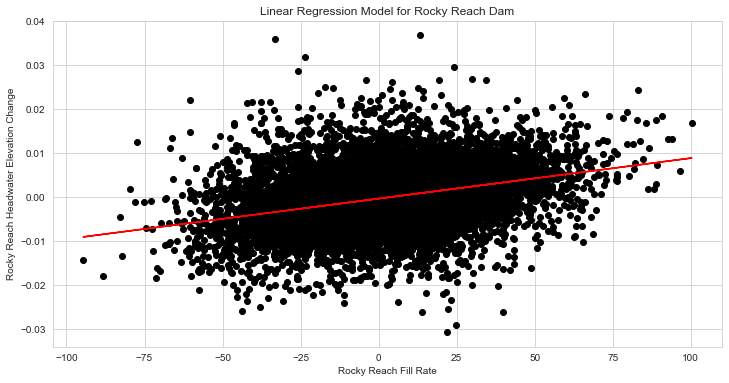

In [24]:
# Ploting the regression line for Rocky Reach Dam on 30 minute intervals
plt.figure(figsize=(12, 6))
plt.scatter(X_test_rocky_reach, y_test_rocky_reach, color='black')
plt.plot(X_test_rocky_reach, y_pred_rocky_reach, color='red')
plt.title('Linear Regression Model for Rocky Reach Dam')
plt.xlabel('Rocky Reach Fill Rate')
plt.ylabel('Rocky Reach Headwater Elevation Change')

plt.show()

### Rock Island

In [25]:
# Prepare data for modeling for Rocky Reach Dam using the resampled data
X_rock_island = df_resampled[['Rock_Island_Fill_Rate']]
y_rock_island = df_resampled['Rock_Island_Headwater_Elevation_Change']

# Split the data into training and testing sets
X_train_rock_island, X_test_rock_island, y_train_rock_island, y_test_rock_island = train_test_split(
    X_rock_island, y_rock_island, test_size=0.2, random_state=42
)

# Create a linear regression model for Rocky Reach Dam
model_rock_island = LinearRegression()

# Train the model for Rocky Reach Dam
model_rock_island.fit(X_train_rock_island, y_train_rock_island)

# Make predictions on the test set for Rocky Reach Dam
y_pred_rock_island = model_rock_island.predict(X_test_rock_island)

# Evaluate the model for Rocky Reach Dam
mse_rock_island = mean_squared_error(y_test_rock_island, y_pred_rock_island)
r2_rock_island = r2_score(y_test_rock_island, y_pred_rock_island)

In [26]:
print(f'Mean Squared Error for Rocky Reach Dam: {mse_rock_island}')
print(f'R-squared for Rocky Reach Dam: {r2_rock_island}')

Mean Squared Error for Rocky Reach Dam: 3.1841362387041025e-05
R-squared for Rocky Reach Dam: 0.39850072568937156


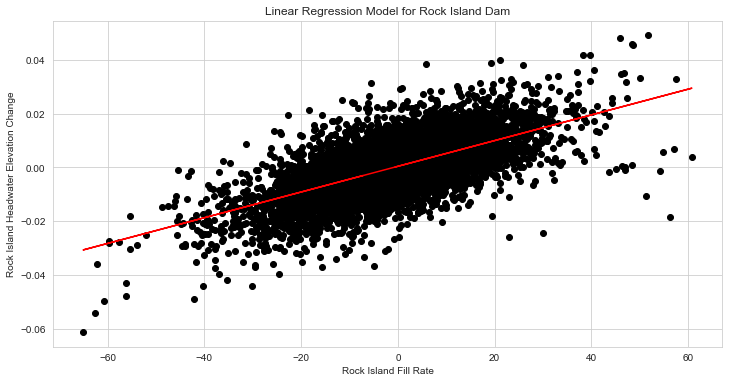

In [27]:
# Ploting the regression line for Rock Island Dam on 30 minute intervals
plt.figure(figsize=(12, 6))
plt.scatter(X_test_rock_island, y_test_rock_island, color='black')
plt.plot(X_test_rock_island, y_pred_rock_island, color='red')
plt.title('Linear Regression Model for Rock Island Dam')
plt.xlabel('Rock Island Fill Rate')
plt.ylabel('Rock Island Headwater Elevation Change')

plt.show()

## PCA Analysis:

In [28]:
# Adding Lag variables 
for lag in range(1, 3):
    df_resampled[f'Rocky_Reach_Headwater_Elevation_lag_{lag}h'] = df_resampled['Rocky_Reach_Headwater_Elevation'].shift(lag)

for lag in range(1, 3):
   df_resampled[f'Rocky_Reach_Total_Discharge_lag_{lag}h'] = df_resampled['Rocky_Reach_Total_Discharge'].shift(lag)
df_resampled.columns

Index(['datetime_utc', 'Wells_Total_Discharge', 'Chelan_Flow', 'Entiat_Flow',
       'Rocky_Reach_Total_Discharge', 'Wenatchee_Flow',
       'Rock_Island_Total_Discharge', 'Rock_Island_Headwater_Elevation',
       'Rocky_Reach_Headwater_Elevation', 'Wells_Flow_Impact',
       'Chelan_Flow_Impact', 'Entiat_Flow_Impact', 'Rocky_Reach_Inflow',
       'Rocky_Reach_Flow_Impact', 'Wenatchee_Flow_Impact',
       'Rock_Island_Inflow', 'Rocky_Reach_Fill_Rate', 'Rock_Island_Fill_Rate',
       'Rocky_Reach_Headwater_Elevation_Change',
       'Rock_Island_Headwater_Elevation_Change',
       'Rocky_Reach_Headwater_Elevation_lag_1h',
       'Rocky_Reach_Headwater_Elevation_lag_2h',
       'Rocky_Reach_Total_Discharge_lag_1h',
       'Rocky_Reach_Total_Discharge_lag_2h'],
      dtype='object')

In [29]:
# List of unnecessary columns to drop
columns_to_drop = ['datetime_utc', 'Wells_Total_Discharge','Chelan_Flow', 'Entiat_Flow', 
                   'Wenatchee_Flow', 'Rock_Island_Total_Discharge', 'Rock_Island_Headwater_Elevation']

# Drop the unnecessary columns
df_rr = df_resampled.drop(columns=columns_to_drop).copy()

# Drop rows with missing values
df_rr.dropna(inplace=True)

In [30]:
df_rr.shape

(87646, 17)

In [32]:
# Separate features and target
target = 'Rocky_Reach_Headwater_Elevation'
X = df_rr.drop(columns=[target])
y = df_rr[target]  # Target

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

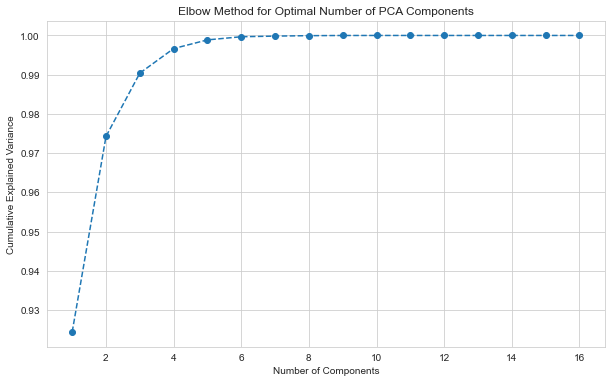

In [33]:
n_components = X.shape[1]

pca = PCA(n_components=n_components).fit(X)
cumulative_explained_variance = np.cumsum(pca.explained_variance_ratio_)

plt.figure(figsize=(10, 6))
plt.plot(range(1, n_components + 1), cumulative_explained_variance, marker='o', linestyle='--')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Elbow Method for Optimal Number of PCA Components')
plt.grid(True)
plt.show()

In [34]:
# 6 components
pca = PCA(n_components=6)
X_pca = pca.fit_transform(X)

# Splitting the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.3, shuffle=False)

# Model training with Linear Regression
model = LinearRegression()
model.fit(X_train, y_train)

# Predictions and evaluation
y_pred = model.predict(X_test)
print("Mean Squared Error for Rocky Reach Dam:", mean_squared_error(y_test, y_pred))
print("R-Squared for Rocky Reach Dam:", r2_score(y_test, y_pred))

Mean Squared Error for Rocky Reach Dam: 0.3355255828159131
R-Squared for Rocky Reach Dam: 0.2261119133177848


## Time Series Models: 

### Rock Island

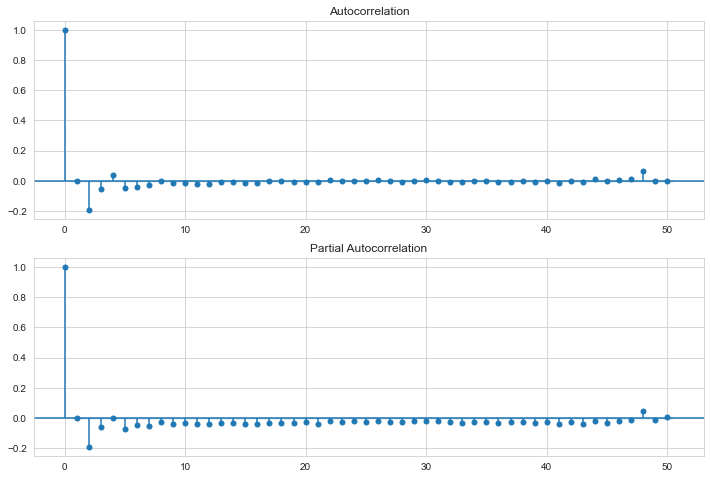

In [36]:
# Convert index to datetime if it's not already
df_resampled.index = pd.to_datetime(df_resampled.index)

# Plot autocorrelation and partial autocorrelation
fig, ax = plt.subplots(2, 1, figsize=(12, 8))
plot_acf(df_resampled['Rock_Island_Headwater_Elevation_Change'], lags=50, ax=ax[0])
plot_pacf(df_resampled['Rock_Island_Headwater_Elevation_Change'], lags=50, ax=ax[1])
plt.show()

There is strong correlation between an obeservarion and its immediate previous observation as shown in the ACF. This also suggests that there is a seasonality trend. Lag 2 shows that there is a negative correlation between an obseration and the observation 2 time periods ago. This suggests that there might be some periodic behavior or cyclical pattern in the data.

In [39]:
# Extract the time series data
df_resampled.index = pd.to_datetime(df_resampled.index)
ts_data = df_resampled['Rock_Island_Headwater_Elevation_Change']

# Splitting data into training and testing sets
train_data, test_data = train_test_split(ts_data, test_size=0.2, random_state=42)

# Parameter Estimation 
# You can choose appropriate values for p, d, and q based on the plots
p = 1  # Autoregressive (AR) order
d = 0  # Differencing (I) order
q = 1  # Moving Average (MA) order

# Fit ARIMA model to the data
model = ARIMA(ts_data, order=(p, d, q))
results = model.fit()

# Model Diagnostic Checking
print(results.summary())

/Users/aves/Downloads/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency N will be used.
  warnings.warn('No frequency information was'
/Users/aves/Downloads/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency N will be used.
  warnings.warn('No frequency information was'
/Users/aves/Downloads/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency N will be used.
  warnings.warn('No frequency information was'


                                         SARIMAX Results                                          
Dep. Variable:     Rock_Island_Headwater_Elevation_Change   No. Observations:                87648
Model:                                     ARIMA(1, 0, 1)   Log Likelihood              307309.786
Date:                                    Tue, 27 Feb 2024   AIC                        -614611.571
Time:                                            11:32:40   BIC                        -614574.047
Sample:                                        01-01-1970   HQIC                       -614600.115
                                             - 01-01-1970                                         
Covariance Type:                                      opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const      -6.091e-06   2.43e-05     -0.251      0